In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys


In [2]:
test_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_X_data.csv")
train_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_X_data.csv")
test_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_y_data.csv")
train_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_y_data.csv")

# Oversampling

In [3]:
from imblearn.under_sampling import EditedNearestNeighbours

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
#ENN reduces the majority class by keeping only well separated instances
enn = EditedNearestNeighbours(sampling_strategy = "all", n_neighbors = 3)
#train_data_X, train_data_y = enn.fit_resample(train_data_X, train_labels_encoded)

In [5]:
from imblearn.combine import SMOTEENN

# Combine SMOTE (oversampling) and ENN (cleaning majority class)
smote_enn = SMOTEENN(sampling_strategy="auto", enn = enn, random_state=42)

# Apply SMOTEENN
train_data_X, train_data_y = smote_enn.fit_resample(train_data_X, train_labels_encoded)

# Check the class distribution after resampling
from collections import Counter
print(f"Class distribution after resampling: {Counter(train_data_y)}")

Class distribution after resampling: Counter({'0': 1})


# Feature Selection

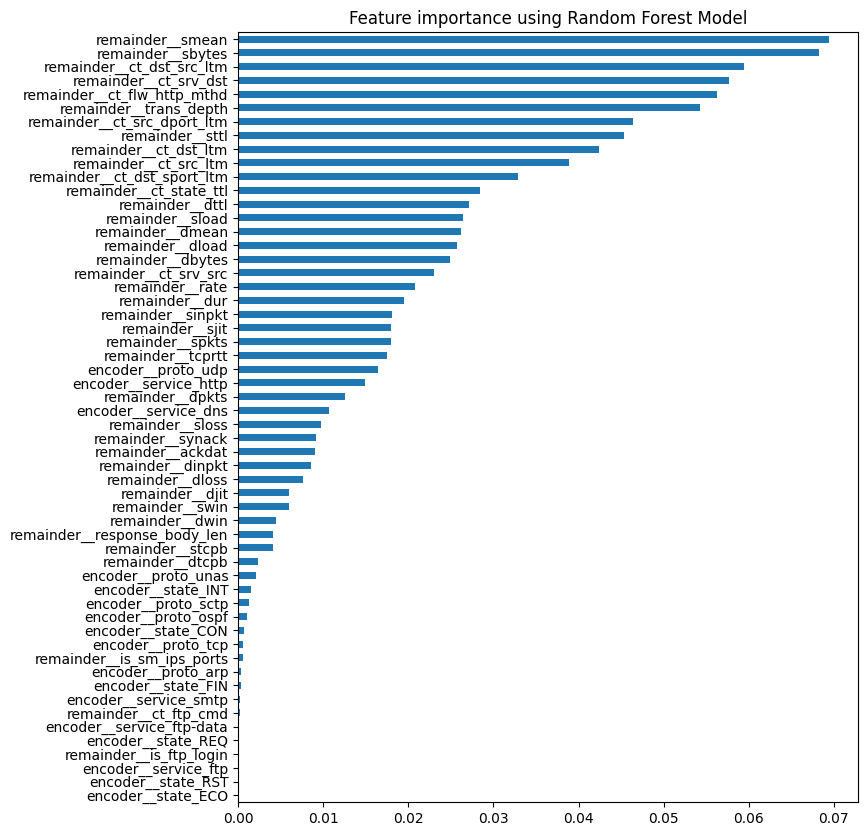

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=15)
numeric_cols = train_data_X.select_dtypes(include = "number")
rf_classifier.fit(numeric_cols, train_data_y.values.ravel())

feature_importances = pd.Series(rf_classifier.feature_importances_, index=numeric_cols.columns)

def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(feature_importances, 'Random Forest')

In [7]:
feature_importances

encoder__proto_arp              0.000311
encoder__proto_ospf             0.001044
encoder__proto_sctp             0.001308
encoder__proto_tcp              0.000619
encoder__proto_udp              0.016380
encoder__proto_unas             0.002054
encoder__service_dns            0.010718
encoder__service_ftp            0.000065
encoder__service_ftp-data       0.000163
encoder__service_http           0.014931
encoder__service_smtp           0.000242
encoder__state_CON              0.000703
encoder__state_ECO              0.000002
encoder__state_FIN              0.000307
encoder__state_INT              0.001511
encoder__state_REQ              0.000159
encoder__state_RST              0.000004
remainder__dur                  0.019442
remainder__spkts                0.017945
remainder__dpkts                0.012584
remainder__sbytes               0.068248
remainder__dbytes               0.024869
remainder__rate                 0.020755
remainder__sttl                 0.045384
remainder__dttl 

In [8]:
top_40_features = [
    "sttl",
    "PC1",
    "dttl",
    "ct_dst_src_ltm",
    "ct_dst_ltm",
    "ct_dst_sport_ltm",
    "ct_state_ttl",
    "ct_src_dport_ltm",
    "ct_src_ltm",
    "ct_srv_dst",
    "ct_srv_src",
    "ackdat",
    "tcprtt",
    "sbytes",
    "smean",
    "dload",
    "rate",
    "dmean",
    "dur",
    "PC3",
    "PC10",
    "dbytes",
    "synack",
    "PC2",
    "ct_flw_http_mthd",
    "trans_depth",
    "PC4",
    "sload",
    "PC5",
    "sinpkt",
    "PC8",
    "spkts",
    "dpkts",
    "PC9",
    "sloss",
    "sjit",
    "PC7",
    "dloss",
    "dwin",
    "swin"
]

In [9]:
from sklearn.feature_selection import f_classif #computes ANOVA 
from sklearn.feature_selection import SelectKBest  #Orders f statistics and selects the Kbest ones

def anova_test():

    
    X_vars = train_data_X[train_data_X.select_dtypes(include='number').columns]
    
    y_var = train_data_y
    
    anova = SelectKBest(f_classif, k=40) #we choose to keep the 10 best ones, try different numbers
    
    
    X_anova = anova.fit_transform(X_vars, y_var)
    
    anova_results = pd.DataFrame({'Feature': X_vars.columns, 
                                  'F-value': anova.scores_,
                                  'p-value': anova.pvalues_})
    
    anova_results.sort_values(by='F-value', ascending=False, inplace=True)

    
    selected_features = pd.Series(anova.get_support(), index = X_vars.columns)
    features_to_use = [feature for feature, keep in selected_features.items() if keep]

    features_to_use_str = '", "'.join(features_to_use)
    
    return selected_features, anova_results, features_to_use_str,features_to_use

In [10]:
selected_features, anova_results, features_to_use_str,features_to_use = anova_test()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
features = features_to_use

# Modelling

## Modelling EfficentKan

In [12]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[features_to_use].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[features_to_use].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()
test_Y_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.long).squeeze()
#a dictionary with the 4 datasets

In [13]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [14]:

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modelling with efficient Kan

In [16]:
from efficient_kan import KAN

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define model
model = KAN([40, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [18]:
model.grid_size, model.spline_order

(5, 3)

In [19]:
from sklearn.model_selection import KFold

In [20]:
model = KAN([40, 20,6, 3,10],grid_size = 3, scale_noise=0.2, scale_base=0.2, scale_spline=0.2)

In [21]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.286148  [    0/481450]
loss: 2.303674  [ 3200/481450]
loss: 2.244631  [ 6400/481450]
loss: 2.213986  [ 9600/481450]
loss: 2.136511  [12800/481450]
loss: 2.161938  [16000/481450]
loss: 2.113140  [19200/481450]
loss: 1.968425  [22400/481450]
loss: 2.088135  [25600/481450]
loss: 2.063952  [28800/481450]
loss: 2.090575  [32000/481450]
loss: 1.949890  [35200/481450]
loss: 1.957240  [38400/481450]
loss: 1.855549  [41600/481450]
loss: 1.948665  [44800/481450]
loss: 1.776588  [48000/481450]
loss: 1.802523  [51200/481450]
loss: 1.592133  [54400/481450]
loss: 1.724606  [57600/481450]
loss: 1.631809  [60800/481450]
loss: 1.875248  [64000/481450]
loss: 1.739676  [67200/481450]
loss: 1.412294  [70400/481450]
loss: 1.457785  [73600/481450]
loss: 1.822690  [76800/481450]
loss: 1.638276  [80000/481450]
loss: 1.328319  [83200/481450]
loss: 1.246202  [86400/481450]
loss: 1.710122  [89600/481450]
loss: 1.127563  [92800/481450]
loss: 1.537654  [96000/481450]

In [23]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
    

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [24]:
model = KAN([40, 20,6, 3,10],grid_size = 3, scale_noise=0.2)

In [25]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303873  [    0/481450]
loss: 2.302816  [ 3200/481450]
loss: 2.297785  [ 6400/481450]
loss: 2.296031  [ 9600/481450]
loss: 2.288023  [12800/481450]
loss: 2.277872  [16000/481450]
loss: 2.235938  [19200/481450]
loss: 2.178953  [22400/481450]
loss: 2.070969  [25600/481450]
loss: 2.067049  [28800/481450]
loss: 2.037387  [32000/481450]
loss: 1.985152  [35200/481450]
loss: 1.862195  [38400/481450]
loss: 1.924645  [41600/481450]
loss: 1.855682  [44800/481450]
loss: 1.714819  [48000/481450]
loss: 2.010747  [51200/481450]
loss: 2.028619  [54400/481450]
loss: 1.706535  [57600/481450]
loss: 1.761786  [60800/481450]
loss: 1.650376  [64000/481450]
loss: 1.897968  [67200/481450]
loss: 1.528954  [70400/481450]
loss: 1.595967  [73600/481450]
loss: 1.435996  [76800/481450]
loss: 1.479889  [80000/481450]
loss: 1.480312  [83200/481450]
loss: 1.585973  [86400/481450]
loss: 1.508904  [89600/481450]
loss: 1.325055  [92800/481450]
loss: 1.312539  [96000/481450]

In [26]:
model = KAN([40, 15,6, 3,10],grid_size = 4, scale_noise=0.2)

In [27]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301274  [    0/481450]
loss: 2.301294  [ 3200/481450]
loss: 2.304498  [ 6400/481450]
loss: 2.282434  [ 9600/481450]
loss: 2.293563  [12800/481450]
loss: 2.281860  [16000/481450]
loss: 2.257150  [19200/481450]
loss: 2.191207  [22400/481450]
loss: 2.114937  [25600/481450]
loss: 2.208935  [28800/481450]
loss: 2.202476  [32000/481450]
loss: 2.015805  [35200/481450]
loss: 1.955566  [38400/481450]
loss: 2.077241  [41600/481450]
loss: 1.912466  [44800/481450]
loss: 1.915923  [48000/481450]
loss: 1.718047  [51200/481450]
loss: 1.702236  [54400/481450]
loss: 1.732891  [57600/481450]
loss: 1.761831  [60800/481450]
loss: 1.929140  [64000/481450]
loss: 1.679223  [67200/481450]
loss: 1.805556  [70400/481450]
loss: 1.505187  [73600/481450]
loss: 1.397231  [76800/481450]
loss: 1.350367  [80000/481450]
loss: 1.515566  [83200/481450]
loss: 1.460700  [86400/481450]
loss: 1.365919  [89600/481450]
loss: 1.382560  [92800/481450]
loss: 1.491446  [96000/481450]

In [28]:
model = KAN([40, 10,6, 3,10],grid_size = 4, scale_noise=0.2)

In [29]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299554  [    0/481450]
loss: 2.301553  [ 3200/481450]
loss: 2.295126  [ 6400/481450]
loss: 2.291452  [ 9600/481450]
loss: 2.284972  [12800/481450]
loss: 2.269739  [16000/481450]
loss: 2.189251  [19200/481450]
loss: 2.225468  [22400/481450]
loss: 2.036146  [25600/481450]
loss: 2.160871  [28800/481450]
loss: 1.978571  [32000/481450]
loss: 1.906189  [35200/481450]
loss: 1.914405  [38400/481450]
loss: 1.971960  [41600/481450]
loss: 1.897991  [44800/481450]
loss: 1.906381  [48000/481450]
loss: 1.966027  [51200/481450]
loss: 1.875139  [54400/481450]
loss: 1.954501  [57600/481450]
loss: 1.790950  [60800/481450]
loss: 1.728896  [64000/481450]
loss: 1.609065  [67200/481450]
loss: 1.730175  [70400/481450]
loss: 1.890268  [73600/481450]
loss: 1.607302  [76800/481450]
loss: 1.749880  [80000/481450]
loss: 1.549158  [83200/481450]
loss: 1.623417  [86400/481450]
loss: 1.741142  [89600/481450]
loss: 1.583601  [92800/481450]
loss: 1.636041  [96000/481450]

In [30]:
# Smoothing function using a moving average
def smooth_loss(losses, window_size=100):
    """
    Smooth the loss values using a moving average.
    :param losses: List of loss values.
    :param window_size: Size of the moving window.
    :return: Smoothed loss values.
    """
    smoothed_losses = np.convolve(losses, np.ones(window_size) / window_size, mode='valid')
    return smoothed_losses

# Plot the training loss over time
plt.figure(figsize=(10, 6))

# Smooth and plot training loss for each fold
for fold, losses in enumerate(all_losses):
    smoothed_loss = smooth_loss(losses, window_size=100)  # Adjust window_size as needed
    plt.plot(smoothed_loss, label=f'Fold {fold + 1}')

# Calculate and plot the average smoothed loss across folds
avg_loss = np.mean(all_losses, axis=0)
smoothed_avg_loss = smooth_loss(avg_loss, window_size=100)
plt.plot(smoothed_avg_loss, label='Average Loss', linewidth=2, color='black')

plt.xlabel('Mini-Batch Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Mini-Batches (Smoothed)')
plt.legend()
plt.show()

NameError: name 'all_losses' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
print(f"Total Mini-Batches per Epoch: {len(trainloader)}")

# Confusion Matrix

In [ ]:
import pickle
import pandas as pd

# Load the LabelEncoder object from the file
with open(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


# Now you can use the label_encoder object in the second notebook
original_class_labels = label_encoder.classes_

In [ ]:
original_labels_test = label_encoder.inverse_transform(test_labels_encoded.values.flatten())

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(test_X_tensor)  # Forward pass
    y_pred = torch.argmax(y_pred, dim=1)  # Get class predictions

# Convert tensors to NumPy arrays for sklearn
y_pred = y_pred.cpu().numpy()
y_true = test_Y_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

fig, ax = plt.subplots(figsize=(12, 8))  #Creates both a figure and an ax

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate axis labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
import torch.nn.functional as F

with torch.no_grad():
    y_score = F.softmax(model(test_X_tensor), dim=1)

In [ ]:
np.average(y_score.numpy())

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_data_y)
y_onehot_test = label_binarizer.transform(test_labels_encoded)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)